<a href="https://colab.research.google.com/github/LoreJob/DeepFake-Dct/blob/main/CNN_for_DeepFake_Detection_in_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN for DeepFake Detection


# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Ram/Disk on the upper-left part of the colab → Additional Connection Options
- select GPU T4 from the Hardware Accelerator drop-down (You have just 1 hour of using)

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
11.85184312700001
GPU (s):
0.24886081799999715
GPU speedup over CPU: 47x


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Importing the directory from GitHub


In [ ]:
!git clone https://github.com/LoreJob/DeepFake-Dct.git

Cloning into 'DeepFake-Dct'...
remote: Enumerating objects: 292081, done.
remote: Counting objects: 100% (118867/118867), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 292081 (delta 118720), reused 118862 (delta 118715), pack-reused 173214
Receiving objects: 100% (292081/292081), 1.80 GiB | 35.66 MiB/s, done.
Resolving deltas: 100% (118720/118720), done.
Updating files: 100% (500685/500685), done.


## Packages
As the title says, we are using the tensorflow package.

In [ ]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

## Importing the dataset
The dataset contains 3 folders:
1. Train, with 140k images divided 50% in Real and Fake;
2. Validation, with 39k images divided 50% in Real and Fake;
3. Test, with 10k images divided 50% in Real and Fake.

Our images are 256x256 pixels.


In [ ]:
data_dir = "/content/DeepFake-Dct/dataset big"

In [ ]:
os.listdir(data_dir)

['Test', 'Train', 'Validation', '.DS_Store']

In [ ]:
print(len( os.listdir((os.path.join(data_dir,'Train','Real')))))
print(len( os.listdir((os.path.join(data_dir,'Train','Fake')))))

70001
70001


In [ ]:
for image_class in os.listdir((os.path.join(data_dir,'Train','Real'))):
  print(image_class)
  break

real_31955.jpg


In [ ]:
img = cv2.imread(os.path.join(data_dir,'Train','Real','real_0.jpg'))

In [ ]:
type(img)

numpy.ndarray

In [ ]:
img.shape

(256, 256, 3)

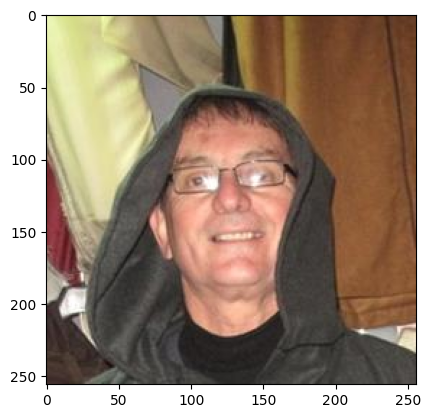

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Create the train and validation

In [ ]:
data_direct = "/content/DeepFake-Dct/dataset big/Train"
train_data = tf.keras.utils.image_dataset_from_directory(data_direct)

data_iterator = train_data.as_numpy_iterator()

batch = data_iterator.next()

print(len(batch))

Found 140002 files belonging to 2 classes.
2


In [ ]:
batch[0].shape

(32, 256, 256, 3)

In [ ]:
batch[1]

array([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1], dtype=int32)

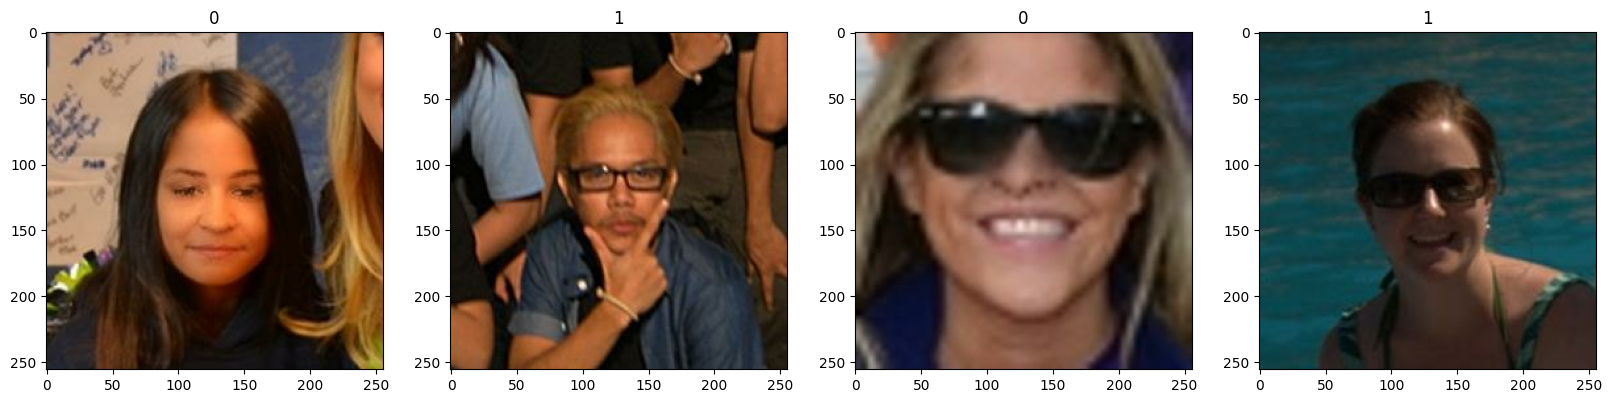

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    data_direct,
    image_size=(256, 256),
    batch_size=32,
    seed=123
)

Found 140002 files belonging to 2 classes.


In [ ]:
val_data = tf.keras.utils.image_dataset_from_directory(
    "/content/DeepFake-Dct/dataset big/Validation",
    image_size=(256, 256),
    batch_size=32,
    seed=123
)

Found 39428 files belonging to 2 classes.


## INCEPTION V3



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# Number of classes in your dataset
num_classes = 2  # Replace with the actual number of classes in your dataset

# Load the InceptionV3 model, excluding the top fully connected layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with 1024 neurons and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add the final output layer with softmax activation for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model by combining the base model and the custom layers
model = Model(inputs=base_model.input, outputs=predictions)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()

# Data generators for training and validation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    '/content/DeepFake-Dct/dataset big/Train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'  # One-hot encoded labels
)

val_data = val_datagen.flow_from_directory(
    '/content/DeepFake-Dct/dataset big/Validation',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'  # One-hot encoded labels
)



checkpoint = ModelCheckpoint(
    filepath='/content/DeepFake-Dct/models/model_epoch_{epoch:02d}.h5',  # Save model file for each epoch
    save_freq='epoch'  # Save every epoch
)

# Train the model with the ModelCheckpoint callback
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[checkpoint]  # Include the checkpoint callback
)

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4376/4376 [==============================] - 1523s 338ms/step - loss: 0.1006 - accuracy: 0.9582 - val_loss: 0.1247 - val_accuracy: 0.9553
Epoch 2/10
4376/4376 [==============================] - 1458s 333ms/step - loss: 0.0561 - accuracy: 0.9779 - val_loss: 0.0739 - val_accuracy: 0.9731
Epoch 3/10
4376/4376 [==============================] - 1464s 335ms/step - loss: 0.0439 - accuracy: 0.9828 - val_loss: 0.0761 - val_accuracy: 0.9745
Epoch 4/10
4376/4376 [==============================] - 1464s 335ms/step - loss: 0.0381 - accuracy: 0.9852 - val_loss: 0.0747 - val_accuracy: 0.9722
Epoch 5/10
4376/4376 [==============================] - 1461s 334ms/step - loss: 0.0307 - accuracy: 0.9874 - val_loss: 0.0573 - val_accuracy: 0.9795
Epoch 6/10
4376/4376 [==============================] - 1460s 334ms/step - loss: 0.0284 - accuracy: 0.9884 - val_loss: 0.0612 - val_accuracy: 0.9781
Epoch 7/10
4376/4376 [==============================] - 1463s 334ms/step - loss: 0.0252 - accuracy: 0.9899 - val_loss

## Creating the model

We are using a CNN with 21 layers divided in:
- 1 Rescaling for data processing;
- 5 layers for data agumentation;
and the CNN with:
- 4 Conv2D with ReLu function, progressive;
- 4 MaxPooling
- 4 Dropout (3 of 10% and the last one of 25%);
- 2 Dense (1 ReLu an the last one Sigmoid);
- 1 Flatten


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = models.Sequential([
    # Preprocessing
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),

    # Data Augmentation
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2, fill_mode = "nearest"),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.2, 0.2),

    # CNN

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout layer with 10% rate

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout layer with 10% rate

    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout layer with 10% rate

    layers.Conv2D(256, (3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.25), # Dropout layer with 25% rate
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_23 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                   

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.h5',
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch')


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/10
4376/4376 [==============================] - 642s 145ms/step - loss: 0.5359 - accuracy: 0.7989 - val_loss: 0.4736 - val_accuracy: 0.8206
Epoch 2/10
4376/4376 [==============================] - 590s 135ms/step - loss: 0.3488 - accuracy: 0.8894 - val_loss: 0.3752 - val_accuracy: 0.8734
Epoch 3/10
4376/4376 [==============================] - 592s 135ms/step - loss: 0.2824 - accuracy: 0.9206 - val_loss: 0.3120 - val_accuracy: 0.9049
Epoch 4/10
4376/4376 [==============================] - 595s 136ms/step - loss: 0.2532 - accuracy: 0.9336 - val_loss: 0.2968 - val_accuracy: 0.9093
Epoch 5/10
4376/4376 [==============================] - 610s 139ms/step - loss: 0.2348 - accuracy: 0.9398 - val_loss: 0.2834 - val_accuracy: 0.9154
Epoch 6/10
4376/4376 [==============================] - 583s 133ms/step - loss: 0.2201 - accuracy: 0.9452 - val_loss: 0.2699 - val_accuracy: 0.9190
Epoch 7/10
4375/4376 [============================>.] - ETA: 0s - loss: 0.2093 - accuracy: 0.9485

### Testing the model

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory(
    "/content/DeepFake-Dct/dataset big/Test",
    image_size=(256, 256),
    batch_size=32,
    seed=123
)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_data)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")